MARKET BASKET ANALYSIS

DATA SOURCE:
https://www.kaggle.com/carrie1/ecommerce-data/version/1

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

1. Introduction:

The dataset is from e-commerce website.
This data has been extracted from "https://www.kaggle.com/carrie1/ecommerce-data"

In [84]:
#imports

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from draw_rules_graph import draw_graph

CREATING AND INSPECTING DATA FRAME

In [85]:
data = 'e_commerce_data.csv'
df = pd.read_csv(data, encoding = 'ISO-8859-1')
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [86]:
print(df.shape)
print(df.describe())

(541909, 8)
            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000


In [87]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

2. Data Wrangling

Inspecting the number of rows with NaN values in each column

In [88]:
np.sum(df.isna())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

There are 135080 nan values for CustomerID, and 1454 for Description.

Customer ID column has too many NaN values, so it is not feasbile to drop all of them. Therefore, this entire column is being dropped as it is also not particularly useful in market basket analysis

In [89]:
#dropping CustomerID column

df_no_customer = df.drop('CustomerID', axis=1)


In [90]:
#dropping all the NaN values
clean_df = df_no_customer.dropna() 

In [91]:
#reinspecting nans

np.sum(clean_df.isna())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
Country        0
dtype: int64

Inspecting unique values in the Description columnn as strip() function is going to be applied to understand values with leading and trailing blanks

In [92]:
len(clean_df['Description'].unique())

4223

In [93]:
clean_df['Description'] = clean_df['Description'].str.strip()

C:\Users\aishj\AppData\Local\Temp/ipykernel_17568/543909773.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['Description'] = clean_df['Description'].str.strip()


In [94]:
len(clean_df['Description'].unique())


4211

According to:
https://www.kaggle.com/carrie1/ecommerce-data/discussion/224365

InvoiceNo starting with "C" featuring negative values are return transactions. After inspecting the df it looks like there are no cunterparts not starting with 'C' of InvoceNo starting with 'C'. This means that return transactions are considered as new transactions and are not related to their original ones. Therefore, without being able to associate their original transaction in order to compute the net difference between purchased and returned items, InvoiceNo starting with C will be dropped

Furthermore, it will also be checked if there are more alphanumeric values

In [95]:
#inspectng InvoiceNo caracters
digits =['0','1','2','3','4','5','6','7','8','9']
character = []

for e in clean_df['InvoiceNo']:
    for i in e:
        if i not in digits:
            character.append(i)
            
np.unique(character)

array(['A', 'C'], dtype='<U1')

Apparently there are transactions starting with A, let's further investigate.

In [96]:
print(clean_df[clean_df['InvoiceNo'].str.contains('A')==True])

       InvoiceNo StockCode      Description  Quantity      InvoiceDate  \
299982   A563185         B  Adjust bad debt         1  8/12/2011 14:50   
299983   A563186         B  Adjust bad debt         1  8/12/2011 14:51   
299984   A563187         B  Adjust bad debt         1  8/12/2011 14:52   

        UnitPrice         Country  
299982   11062.06  United Kingdom  
299983  -11062.06  United Kingdom  
299984  -11062.06  United Kingdom  


In [97]:
#dropping transactions not useful for our analysis 
clean_df = clean_df[~clean_df['InvoiceNo'].str.contains('A')]
clean_df = clean_df[~clean_df['InvoiceNo'].str.contains('C')]
clean_df.reset_index()
print(clean_df['InvoiceNo'].str.contains('A').sum())
print(clean_df['InvoiceNo'].str.contains('C').sum())

0
0


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

3. Data Exploration

Here we are going to explore data to see if the raised questions can be answered or not. If not, we will further model this data to reach to a conclusion

In [98]:
#Names of the country part of our dataset

print(np.unique(clean_df.Country))
print(len(np.unique(clean_df.Country)))

['Australia' 'Austria' 'Bahrain' 'Belgium' 'Brazil' 'Canada'
 'Channel Islands' 'Cyprus' 'Czech Republic' 'Denmark' 'EIRE'
 'European Community' 'Finland' 'France' 'Germany' 'Greece' 'Hong Kong'
 'Iceland' 'Israel' 'Italy' 'Japan' 'Lebanon' 'Lithuania' 'Malta'
 'Netherlands' 'Norway' 'Poland' 'Portugal' 'RSA' 'Saudi Arabia'
 'Singapore' 'Spain' 'Sweden' 'Switzerland' 'USA' 'United Arab Emirates'
 'United Kingdom' 'Unspecified']
38


In [99]:
#creating the profit column

clean_df['Profit'] = clean_df['Quantity']*clean_df['UnitPrice']
clean_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Profit
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,United Kingdom,20.34
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,United Kingdom,15.30
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,United Kingdom,25.50
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,United Kingdom,11.10
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,United Kingdom,11.10
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,United Kingdom,54.08


For the exploratory analysis, and even modelling -- two countries will be investigated, namely, United Kingdom and Netherlands, as they are the top countries with highest profit.

In [100]:
grouped_country = clean_df.groupby(['Country'])['Profit'].sum().reset_index().set_index('Country')

profitable_countries = grouped_country.sort_values('Profit', ascending=False)
profitable_countries.head(10)

,Profit
Country,
United Kingdom,9014160.024
Netherlands,285446.340
EIRE,283453.960
Germany,228867.140
France,209715.110
Australia,138521.310
Spain,61577.110
Switzerland,57089.900
Belgium,41196.340


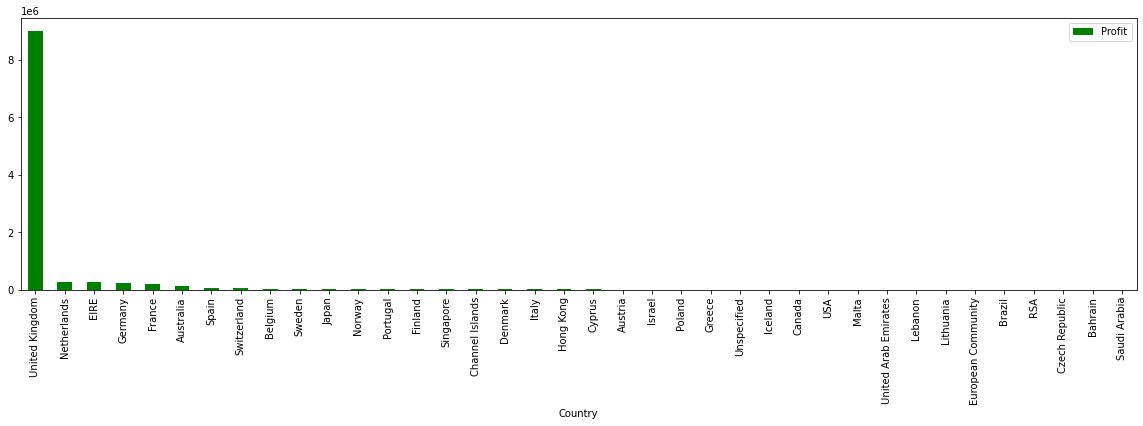

In [101]:
fighist = plt.figure(figsize=(20,5))
ax = fighist.gca()
profitable_countries.plot.bar(color='green', ax=ax)
plt.show()

The two most profitable countries are United Kingdom and the Netherlands, we'll perform the market busket analysis on UK clients.

In [102]:
#filtering out all the other countries
uk_df = clean_df[clean_df['Country']=='United Kingdom']
nd_df = clean_df[clean_df['Country']=='Netherlands']

#checking if the filtering operation worked correctly
print(len(np.unique(uk_df['Country'])))
print(len(np.unique(nd_df['Country'])))

1
1


In [103]:
#dropping transactions not useful for our analysis 
uk_df = uk_df[~uk_df['InvoiceNo'].str.contains('A')]
uk_df = uk_df[~uk_df['InvoiceNo'].str.contains('C')]
uk_df.reset_index()
print(uk_df['InvoiceNo'].str.contains('A').sum())
print(uk_df['InvoiceNo'].str.contains('C').sum())

0
0


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

4. Modelling

In this section, Apriori and Association Rules model will be applied to the dataset, specifically on the InvoiceNo and Description columns to follow the market basket analysis.
Furthermore, the two separate datasets will be created, one grouped by UK and other by the Netherlands as they are the top two selling markets.
Purpose of doing this type of analysis and comparison between the markets is to find the hidden association rules and also explore consumer behavior. 
Ideally such comparison must be done amongst all the countries, but in the scenario only 2 are selected for simplicity and time management purposes.

In [104]:
#grouping and unstaking the df for market busket analysis
baskets_uk = uk_df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

baskets_uk

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [105]:
#encoding to have all 0s and 1s
def encode_units(i):
    if int(i) <= 0:
        return 0
    else:
        return 1
    
encoded_uk = baskets_uk.applymap(encode_units)

In [106]:
encoded_uk.head(10)

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536371,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536372,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536373,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536374,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
frequent_items_uk = apriori(encoded_uk, min_support=0.03, 
                            use_colnames=True, max_len=2)
frequent_items_uk

,support,itemsets
0,0.045808,(6 RIBBONS RUSTIC CHARM)
1,0.031128,(60 CAKE CASES VINTAGE CHRISTMAS)
2,0.040343,(60 TEATIME FAIRY CAKE CASES)
3,0.046933,(ALARM CLOCK BAKELIKE GREEN)
4,0.035146,(ALARM CLOCK BAKELIKE PINK)
...,...,...
126,0.030538,"(JUMBO BAG RED RETROSPOT, JUMBO BAG BAROQUE B..."
127,0.042057,"(JUMBO BAG PINK POLKADOT, JUMBO BAG RED RETROS..."
128,0.035200,"(JUMBO SHOPPER VINTAGE RED PAISLEY, JUMBO BAG ..."
129,0.037396,"(JUMBO STORAGE BAG SUKI, JUMBO BAG RED RETROSPOT)"


In [108]:
rules_uk = association_rules(frequent_items_uk, metric='lift', min_threshold=1)
uk_rules_sorted = rules_uk.sort_values('confidence', ascending=False)
uk_top_10 = uk_rules_sorted[:10]
uk_top_10

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037664,0.050040,0.030913,0.820768,16.402181,0.029029,5.300173
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050040,0.051272,0.037557,0.750535,14.638184,0.034991,3.803054
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051272,0.050040,0.037557,0.732497,14.638184,0.034991,3.551217
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.062095,0.103831,0.042057,0.677308,6.523196,0.035610,2.777166
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.046933,0.049826,0.030163,0.642694,12.898801,0.027825,2.659273
7,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.048754,0.103831,0.030538,0.626374,6.032644,0.025476,2.398571
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050040,0.037664,0.030913,0.617773,16.402181,0.029029,2.517708
12,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.060541,0.103831,0.037396,0.617699,5.949099,0.031110,2.344147
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.049826,0.046933,0.030163,0.605376,12.898801,0.027825,2.415130
10,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.060702,0.103831,0.035200,0.579876,5.584826,0.028897,2.133109


Let's see how it compares to the second most profitable country: Netherlands

In [109]:
#grouping and unstaking the df for market busket analysis - for Netherlands this time. Same process will be run again
baskets_nd = nd_df.groupby(['InvoiceNo','Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('InvoiceNo')

baskets_nd.head(10)

Description,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,...,WRAP RED APPLES,WRAP WEDDING DAY,YELLOW METAL CHICKEN HEART,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539491,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
539731,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,192.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541206,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,192.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
541711,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
542894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [110]:
#encoding to have all 0s and 1s
def encode_units(i):
    if int(i) <= 0:
        return 0
    else:
        return 1
    
encoded_nd = baskets_nd.applymap(encode_units)

In [111]:
encoded_nd.head(10)

Description,10 COLOUR SPACEBOY PEN,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,16 PIECE CUTLERY SET PANTRY DESIGN,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HEARTS HANGING DECORATION RUSTIC,3 HOOK HANGER MAGIC GARDEN,...,WRAP RED APPLES,WRAP WEDDING DAY,YELLOW METAL CHICKEN HEART,ZINC HEART T-LIGHT HOLDER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC WILLIE WINKIE CANDLE STICK
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536403,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
539491,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
539731,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
541206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
541570,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
541608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
541711,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
542720,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
542894,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [112]:
frequent_items_nd = apriori(encoded_nd, min_support=0.03, 
                            use_colnames=True, max_len=2)
frequent_items_nd

,support,itemsets
0,0.052632,(10 COLOUR SPACEBOY PEN)
1,0.042105,(20 DOLLY PEGS RETROSPOT)
2,0.031579,(3 HEARTS HANGING DECORATION RUSTIC)
3,0.073684,(3 HOOK HANGER MAGIC GARDEN)
4,0.063158,(3 PIECE SPACEBOY COOKIE CUTTER SET)
...,...,...
3722,0.042105,"(WHITE WOOD GARDEN PLANT LADDER, STRAWBERRY LU..."
3723,0.094737,"(WOODLAND CHARLOTTE BAG, STRAWBERRY LUNCH BOX ..."
3724,0.031579,"(WOODLAND CHARLOTTE BAG, SUKI SHOULDER BAG)"
3725,0.031579,"(TEA PARTY BIRTHDAY CARD, WHITE WOOD GARDEN PL..."


In [113]:
rules_nd = association_rules(frequent_items_nd, metric='lift', min_threshold=1)

In [114]:
rules_nd = association_rules(frequent_items_nd, metric='lift', min_threshold=1)
nd_rules_sorted = rules_nd.sort_values('confidence', ascending=False)
nd_top_10 = nd_rules_sorted[:10]
nd_top_10

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
5288,(VINTAGE KID DOLLY CARD),(MEMO BOARD COTTAGE DESIGN),0.031579,0.094737,0.031579,1.0,10.555556,0.028587,inf
3060,(FELTCRAFT 6 FLOWER FRIENDS),(DOLLY GIRL LUNCH BOX),0.031579,0.231579,0.031579,1.0,4.318182,0.024266,inf
4846,(STRAWBERRY SHOPPER BAG),(LUNCH BAG PINK POLKADOT),0.031579,0.084211,0.031579,1.0,11.875000,0.028920,inf
4836,(SET/10 PINK POLKADOT PARTY CANDLES),(LUNCH BAG PINK POLKADOT),0.031579,0.084211,0.031579,1.0,11.875000,0.028920,inf
4835,(LUNCH BAG PINK POLKADOT),(ROUND SNACK BOXES SET OF4 WOODLAND),0.084211,0.263158,0.084211,1.0,3.800000,0.062050,inf
1536,(JUMBO BAG APPLES),(CHARLOTTE BAG APPLES DESIGN),0.052632,0.084211,0.052632,1.0,11.875000,0.048199,inf
6309,(SCOTTIE DOGS BABY BIB),(REGENCY CAKESTAND 3 TIER),0.031579,0.094737,0.031579,1.0,10.555556,0.028587,inf
6311,(SET OF 12 FORK CANDLES),(REGENCY CAKESTAND 3 TIER),0.031579,0.094737,0.031579,1.0,10.555556,0.028587,inf
3050,(DOLLY GIRL CHILDRENS CUP),(SPACEBOY CHILDRENS CUP),0.063158,0.084211,0.063158,1.0,11.875000,0.057839,inf
6323,(SKULL AND CROSSBONES GARLAND),(REGENCY CAKESTAND 3 TIER),0.031579,0.094737,0.031579,1.0,10.555556,0.028587,inf


----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
5. Conclusion

The graphs below gives us important insights in terms of hidden association rules (separated by country) in the dataset.


UNITED KINGDOM

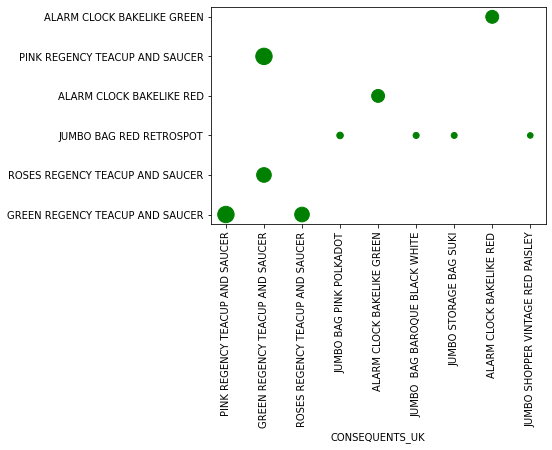

<Figure size 864x576 with 0 Axes>

In [115]:
#solving the frozenlist problem

ant_uk = uk_top_10['antecedents']
cons_uk = uk_top_10['consequents']
conf_uk = uk_top_10['confidence']
lift_uk = uk_top_10['lift']

x1=[]
y1=[]

for i in ant_uk:
    x1.append(sorted(i))
    
for h in cons_uk:
    y1.append(sorted(h))
    
x_flat_uk = [item for sublist in x1 for item in sublist]
y_flat_uk = [item for sublist in y1 for item in sublist]

from matplotlib.pyplot import figure
fig = plt.scatter(x_flat_uk, y_flat_uk, s=lift_uk**2, color='green')
plt.xlabel('ANTECEDENTS_UK')
plt.xlabel('CONSEQUENTS_UK')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 8))
plt.show()

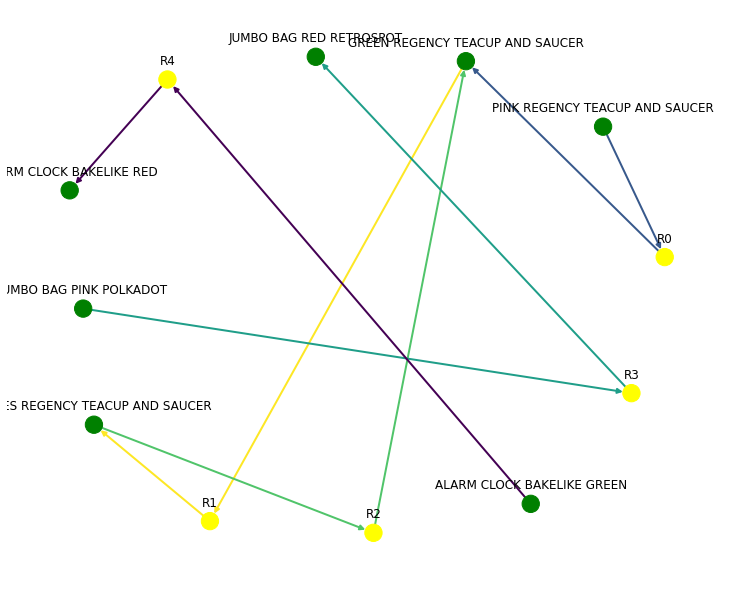

In [116]:
plt.figure(figsize = (10, 8))
draw_graph(uk_top_10)

NETHERLANDS

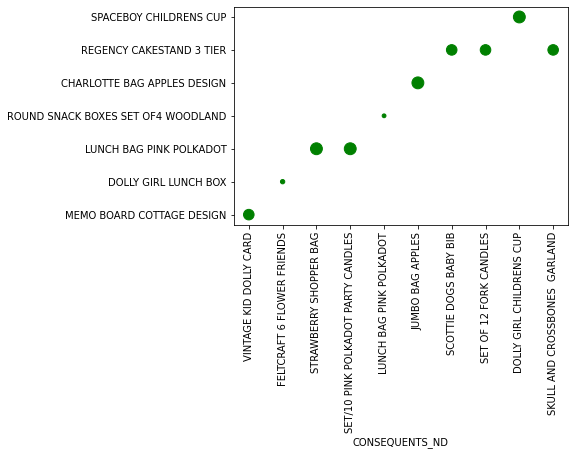

<Figure size 864x576 with 0 Axes>

In [117]:
#solving the frozenlist problem

ant_nd = nd_top_10['antecedents']
cons_nd = nd_top_10['consequents']
conf_nd = nd_top_10['confidence']
lift_nd = nd_top_10['lift']

x2=[]
y2=[]

for i in ant_nd:
    x2.append(sorted(i))
    
for h in cons_nd:
    y2.append(sorted(h))
    
x_flat_nd = [item for sublist in x2 for item in sublist]
y_flat_nd = [item for sublist in y2 for item in sublist]

from matplotlib.pyplot import figure
fig = plt.scatter(x_flat_nd, y_flat_nd, s=lift_nd**2, color='green')
plt.xlabel('ANTECEDENTS_ND')
plt.xlabel('CONSEQUENTS_ND')
plt.xticks(rotation=90)
plt.figure(figsize=(12, 8))
plt.show()

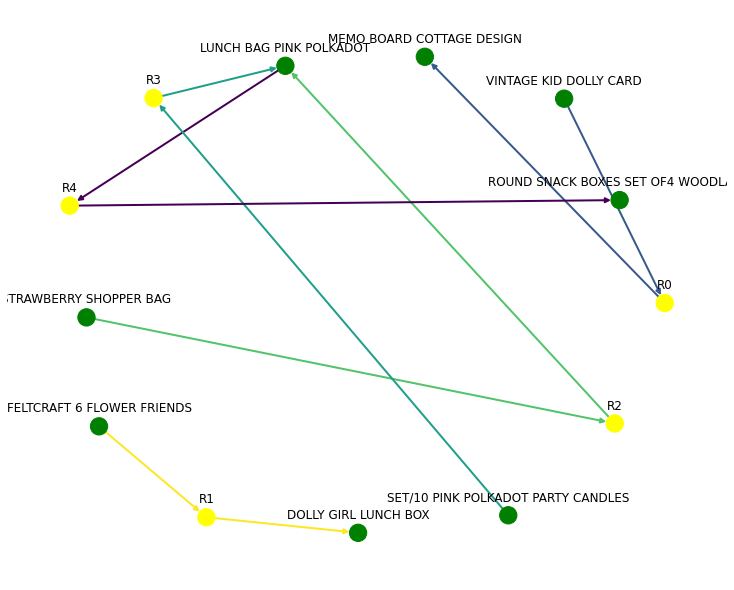

In [118]:
plt.figure(figsize=(10,8))
draw_graph(nd_top_10)

In conclusion:
Before initiating, 2 questions were asked of us by ourselves:
1. If a customer purchases product X, what is his/her propensity to purchase product Y?
2. How are the customers from different countries behaving?

After thorough analysis, a conclusion has been achieved.

1. The graphs above, for both UK and Netherlands, show that there are several products for which association rules have been spotted
2. The behavior of customer, as expected, is different, not only in terms of general purchases, but also in terms of their market baskets. Thus, it is better to conduct such market basket analysis on a country basis.

